In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model

import matplotlib.lines as mlinesZ
import json
import datetime
import time
import os
import warnings
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, scale
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight
plt.style.use('seaborn-deep')

# Use this line to enable GPU (only on applicable architecures)
# get_ipython().run_line_magic('env', 'CUDA_DEVICE_ORDER=PCI_BUS_ID')
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # turns off gpu
tf.test.is_gpu_available()

/home/rnewhous/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rnewhous/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rnewhous/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rnewhous/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

False

In [2]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)


In [4]:
# Load tracks from root ntuples

save_columns = [
    # Features used in traditional scoring function
    "numberOfPixelHoles", # output tracks only
    "numberOfSCTHoles", # output tracks only
    "numberOfSCTDoubleHoles", # output tracks only
    "numberOfContribPixelLayers",
    "numberOfBLayerHits",
    "numberOfGangedFlaggedFakes",
    # "numberOfTRTHits",
    # "numberOfTRTOutliers",
    "numberOfPixelHits",
    "numberOfSCTHits",
    # "Sihits",
    "standardDeviationOfChi2OS",
    "track_pt",
    "chiSquared",
    "numberDoF",
    
    # New features not used in traditional score, these may help.
    "numberOfBLayerSplitHits",
    "numberOfInnermostLayerSplitHits",
    "numberOfInnermostPixelLayerHits",
    "numberOfNextToInnermostLayerSplitHits",
    "numberOfNextToInnermostPixelLayerHits",
    "numberOfPixelSplitHits",
    "numberOfPixelOutliers",
    "numberOfSCTOutliers",
    "numberOfPixelSpoiltHits",
    "numberOfSCTSpoiltHits",
    "numberOfGangedPixels",
    "numberOfOutliersOnTrack",
    
    "track_eta",
    # For training and evaluation
    "score",
    "linkValid",
    "truthProbability",  
#     "eventNumber",

]

# This is the directory where each of the training samples are stored, output by InDetTrackSummaryDumpAlg
dir_name = "/fast_scratch/rnewhous/LRT/training/"
# os.chdir(dir_name)

# This specifies the subdirectory where the training samples are stored. I found it useful to seaparate the topologies this way.
samples = glob.glob(dir_name+'track_info_outputs*.root')
# samples = [
#     dir_name+'track_info_InDetSummaryDumpAlg_SiSpSeededLargeD0Tracks.root',
# ]
# print (samples)

In [5]:
# With these huge samples it's necessary to make sure to reduce the memory consumption as much as possible. 
# This function is an attempt at that. Ideally one would use of a generated datasets with a Keras Sequence.
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
# For smaller training sets though this does quite well.
def downsize_dataframe(sample):
    # Use uproot to read the sample and convert to pandas df
    df_tmp = uproot.open(sample).get("tracks").pandas.df(branches=save_columns, 
                                                                            basketcache={}, # Not sure if this actually reduces memory consumption
#                                                                           entrystop=5e5, # Adjust this to determine how many tracks to initially load
                                                                            )

    # We don't care about tracks with zero score since they have been removed by the cuts in the scoring function. Remove them from the dataframe
    df_tmp = df_tmp[df_tmp.score>0]

    # Downcast the datatype to reduce the memory footprint in the dataframe. All feaures are stored as doubles initially but most can be described by integers.
    df_tmp.numberOfPixelHoles = pd.to_numeric(df_tmp.numberOfPixelHoles, downcast='integer')
    df_tmp.numberOfSCTHoles = pd.to_numeric(df_tmp.numberOfSCTHoles, downcast='integer')
    df_tmp.numberOfSCTDoubleHoles = pd.to_numeric(df_tmp.numberOfSCTDoubleHoles, downcast='integer')
    df_tmp.numberOfContribPixelLayers = pd.to_numeric(df_tmp.numberOfContribPixelLayers, downcast='integer')
    df_tmp.numberOfBLayerHits = pd.to_numeric(df_tmp.numberOfBLayerHits, downcast='integer')
    df_tmp.numberOfGangedFlaggedFakes = pd.to_numeric(df_tmp.numberOfGangedFlaggedFakes, downcast='integer')
    df_tmp.numberOfPixelHits = pd.to_numeric(df_tmp.numberOfPixelHits, downcast='integer')
    df_tmp.numberOfSCTHits = pd.to_numeric(df_tmp.numberOfSCTHits, downcast='integer')
    df_tmp.numberDoF = pd.to_numeric(df_tmp.numberDoF, downcast='integer')
    df_tmp.standardDeviationOfChi2OS = pd.to_numeric(df_tmp.standardDeviationOfChi2OS, downcast='float')

    df_tmp.numberOfBLayerSplitHits = pd.to_numeric(df_tmp.numberOfBLayerSplitHits, downcast='integer')
    df_tmp.numberOfInnermostLayerSplitHits = pd.to_numeric(df_tmp.numberOfInnermostLayerSplitHits, downcast='integer')
    df_tmp.numberOfNextToInnermostLayerSplitHits = pd.to_numeric(df_tmp.numberOfNextToInnermostLayerSplitHits, downcast='integer')
    df_tmp.numberOfPixelSplitHits = pd.to_numeric(df_tmp.numberOfPixelSplitHits, downcast='integer')
    df_tmp.numberOfPixelOutliers = pd.to_numeric(df_tmp.numberOfPixelOutliers, downcast='integer')
    df_tmp.numberOfSCTOutliers = pd.to_numeric(df_tmp.numberOfSCTOutliers, downcast='integer')
    df_tmp.numberOfPixelSpoiltHits = pd.to_numeric(df_tmp.numberOfPixelSpoiltHits, downcast='integer')
    df_tmp.numberOfSCTSpoiltHits = pd.to_numeric(df_tmp.numberOfSCTSpoiltHits, downcast='integer')
    df_tmp.numberOfGangedPixels = pd.to_numeric(df_tmp.numberOfGangedPixels, downcast='integer')
    df_tmp.numberOfOutliersOnTrack = pd.to_numeric(df_tmp.numberOfOutliersOnTrack, downcast='integer')
    
    df_tmp.truthProbability = pd.to_numeric(df_tmp.truthProbability, downcast='float')    
    df_tmp.score = pd.to_numeric(df_tmp.score, downcast='float')    
   
    return df_tmp

In [6]:
# Create new pandas dataframe
full_df = pd.DataFrame()
# Sometimes useful to keep track of sample type when training on multiple topologies
sample_type = 0 
# Load all training samples into dataframe
for sample in samples:
    print("oepning", sample)
    df_tmp = downsize_dataframe(sample)
    df_tmp['sample_type'] = sample_type
    sample_type += 1
    
    print("appending to full_df")
    full_df = full_df.append(df_tmp)
    print("done loading", sample)

# One of the variables used in the traditional scoing function is a combination of the
# number of pixel hits and pixel holes. We need to create this variable. 
full_df['Sihits'] = full_df.numberOfPixelHits + full_df.numberOfSCTHits

# Inspect loaded dataframe
print(full_df.columns)
print("Total number of tracks loaded", len(full_df))

oepning /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816637._000006.pool.root.1.19.root
appending to full_df
done loading /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816637._000006.pool.root.1.19.root
oepning /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816649._000004.pool.root.1.5.root
appending to full_df
done loading /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816649._000004.pool.root.1.5.root
oepning /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816637._000005.pool.root.1.15.root
appending to full_df
done loading /fast_scratch/rnewhous/LRT/training/track_info_outputs.PowhegPythia8EvtGen_WpH_H125_a55a55_4b_ctau100.RDO.19816637._000005.pool.root.1.15.root
oepning /fast_scra

In [7]:
# Flattening pt distribution

# This was an initial attempt at flattening the pt distribution. This approach uses subsampling as opposed to sample weighting.
# Flattening the spectrum in this way had the most significant improvement in reconstruction efficiency at pt > 100.
# I will leave this section in since the inital subsampling reduces the number of tracks that the sample weigting
# (in the next section) must deal with.

# Define the histogram bins
d_pt = 1e4; n_bins = 40
bins = np.linspace(0, n_bins*d_pt, n_bins, endpoint=False)

df_flat = pd.DataFrame()
print("Sampling a flat pt spectrum")
MAX_TRACKS = int(1e5)
for i in range(len(bins)-1):
    try:
        # Select tracks in the current bin
        full_df_in_pt_range = full_df[(full_df.track_pt >= bins[i]) & (full_df.track_pt < bins[i+1])]
        # Subsample the tracks in the current pt range
        sampled_tracks = full_df_in_pt_range.sample(MAX_TRACKS)
        # Build a new dataframe from only the subsampled tracks 
        df_flat = df_flat.append(sampled_tracks)
        # Report what has been kept
        print("track_pt:", bins[i], "to", bins[i+1],
              "\t tracks: ",len(full_df_in_pt_range), 
              "\t sampled:",len(sampled_tracks), 
              "({0:.2f}%)".format(100*len(sampled_tracks)/len(full_df_in_pt_range)))
    except ValueError as ex: 
        # The remaining bins don't have enough tracks to subsample, keep them all
        # (Assuming a continuously falling spectrum)
        break
df_rest = full_df[(full_df.track_pt >= bins[i])]
print("track_pt:", bins[i], "to", "inf", "\t tracks: ",len(df_rest), "\t keeping all:",len(df_rest))

Sampling a flat pt spectrum
track_pt: 0.0 to 10000.0 	 tracks:  1609844 	 sampled: 100000 (6.21%)
track_pt: 10000.0 to inf 	 tracks:  81279 	 keeping all: 81279


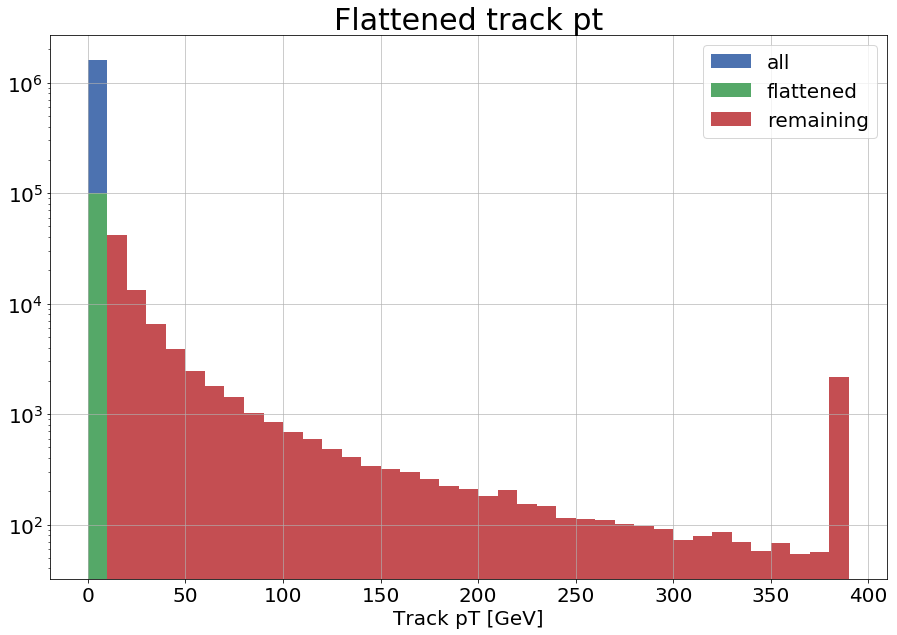

In [8]:
# Plot the results of subsampling the pt spectrum
# The final bin includes the overflow from all tracks beyond the bin limits

ax = (full_df.track_pt.clip(bins[0],bins[-1])/1000).hist(bins=bins/1000, label="all", 
                                                    log=True, figsize=(15,10)) # other figure params
ax.tick_params(direction='out', labelsize=20, grid_alpha=0.8)
ax.set_xlabel("Track pT [GeV]", fontsize=20)

try: (df_flat.track_pt.clip(bins[0],bins[-1])/1000).hist(bins=bins/1000, label="flattened")
except: pass
(df_rest.track_pt.clip(bins[0],bins[-1])/1000).hist(bins=bins/1000, label="remaining")
ax.set_title("Flattened track pt", fontsize = 30)
ax.legend(fontsize=20)

In [9]:
# Caution, this will overwrite the previous full_df variable. 
# To recover the cut-away tracks you will need to reload the root files.
full_df = df_flat.append(df_rest)
print("number of tracks:", len(full_df))

number of tracks: 181279


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of tracks 181279
Number of tracks selected for signal 132560
Number of tracks selected for backgronund 48719


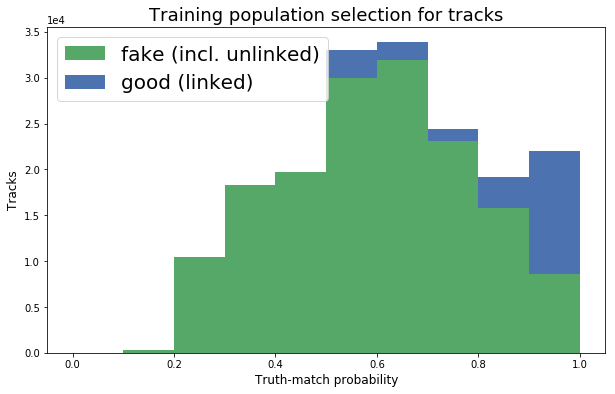

In [10]:
# Selecting classes

# In this work, "good" tracks are those with a truth match probability of greater than or equal to 0.8 
# and "fake" tracks are those with a truth match probability of less than 0.5. 
# These are both arbitrary distinctions, but using 0.5 for fake tracks is the common definition in many tracking analyses. 
# 0.8 was chosen for good tracks to obtain a relatively pure sample of tracks.

sig_min = 0.5
bkg_max = 0.5

# Select and plot track populations
condition = (full_df.truthProbability >= sig_min) & (full_df.linkValid == True)
df_true = full_df[condition]
df_false = full_df[condition == False]

# Label collections with truth value
df_true["signal"] = 1
df_false["signal"] = 0

# Plot distribution
bins = np.linspace(0,1,11)
fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
x = [df_false["truthProbability"], df_true["truthProbability"]]
colors = ['#55A868','#4C72B0']
# Good
ax1.hist(x, histtype='bar', color=colors, alpha=1,  bins=bins, stacked=True)

ax1.set_xlabel("Truth-match probability", fontsize=12)
ax1.set_ylabel("Tracks", fontsize=12)
ax1.set_title("Training population selection for tracks", fontsize=18)
ax1.legend(['fake (incl. unlinked)', 'good (linked)'], fontsize = 20)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ymin, ymax = plt.ylim()
# plt.ylim(ymin,ymax*1.1)

print("Number of tracks", len(full_df))
print("Number of tracks selected for signal", len(full_df[(full_df.truthProbability >= sig_min)]))
print("Number of tracks selected for backgronund", len(full_df[(full_df.truthProbability < bkg_max)]))

upsampling
Total sample size 316098


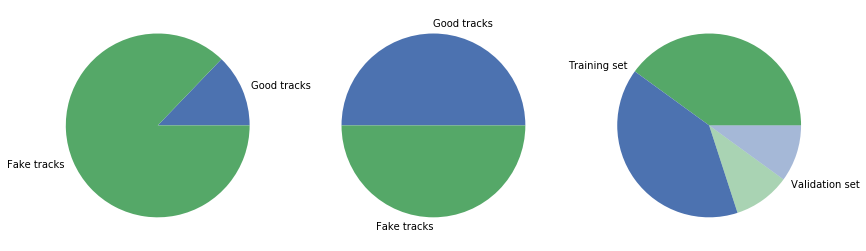

In [11]:
# Balance the classes by subsampling the same number of true and fake tracks
# This is to prevent the network from learning to prefer one class over the other

def upsample(df_true, df_false):
    # I've found other upsampling implementations lose information by using replacement
    # how much bigger?
    if len(df_true) < len(df_false):
        majority = df_false
        minority = df_true
    else:
        majority = df_true
        minority = df_false
        
    print('upsampling')
    ratio_floor = int(np.floor(len(majority)/len(minority)))
    remainder = len(majority) % len(minority)

    temp_df = majority
    
    # append multiplied minority
    temp_df = temp_df.append(
        pd.concat([minority]*ratio_floor, ignore_index=True),
        ignore_index=True)
    
    # append randomly sampled remaining minority
    temp_df = temp_df.append(
        minority.sample(remainder),
        ignore_index=True)
    
    # randomly combined data frame
    return temp_df.sample(frac=1)

def downsample(df_true, df_false):
    initial_len = [len(df_true), len(df_false)]
    sample_len = min(initial_len)
    print('downsampling')
    df_true = df_true.sample(sample_len)
    df_false = df_false.sample(sample_len)

    # Combine and shuffle the true and false dataframes
    return df_true.append(df_false).sample(frac=1)
            
# print(len(downsample(df_true, df_false)))
# print(len(upsample(df_true, df_false)))

# Combine and shuffle the true and false dataframes
initial_len = [len(df_true), len(df_false)]
df = upsample(df_true, df_false)
true_count = len(df[df.signal == 1])
false_count = len(df[df.signal == 0])

# Visualize flow in pie charts
fig, (ax0, ax1, ax2) = plt.subplots(1, 3,figsize=(14,6))
print("Total sample size",len(df))
pie1 = ax0.pie(initial_len, labels=["Good tracks", "Fake tracks"])
pie1 = ax1.pie([true_count, false_count], labels=["Good tracks", "Fake tracks"])
pie2 = ax2.pie([true_count*.4,false_count*.4,true_count*.1,false_count*.1], labels=["","","", ""], colors=["#55A868","#4C72B0","#55A868","#4C72B0"])
pie2[0][2].set_alpha(0.5)
pie2[0][3].set_alpha(0.5)
pie2 = ax2.pie([.8,.2], labels=["Training set", "Validation set"], colors=["b","g"], )
pie2[0][0].set_alpha(0.0)
pie2[0][1].set_alpha(0.0)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6641: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


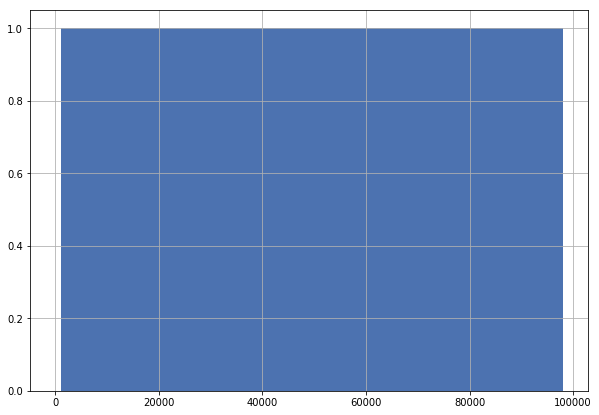

In [12]:
### Weighing tracks by pt
# In this section we weight each track by its inverse histogram weight.
# This can be done after flattening by subsampling.
# The weights will be used in Keras' training to prevent learning the pt distribution of the tracks
# Note: I believe this is important to do after class weighting.

# Define bins and produce histogram
d_pt = 1000; n_bins = 100
bins = np.linspace(0,n_bins*d_pt, n_bins, endpoint=False)
pt_hist, _ = np.histogram(df.track_pt, bins=bins, density=False)

# Guarantee that anything in the highest bin gets a weight of 1. Like a cutoff. Almost all high bins only have a weight of 1
bins[-1] = np.inf
pt_hist[-1] = np.max(pt_hist) # Overflow bin

# Digitize finds which bin each pt value belongs to
pt_bin = np.digitize(df.track_pt, bins)
pt_bin = pt_bin - 1 # indexes from one for some reason (may not understand this fully)

# Define the weights as the inverse of the histogram weights.
# This will give less weight to low-pt tracks since there are many
track_weights = (1/pt_hist[pt_bin])
df['track_weights'] = track_weights

# Sanity check plot. this weighted histogram should be exactly flat.
# Some gaps may appear if no tracks fall in that pt range
ax = df.track_pt.hist(bins=bins, density=False,figsize=(10,7), weights=track_weights)


variables.json written to /fast_scratch/rnewhous/LRT/training/model


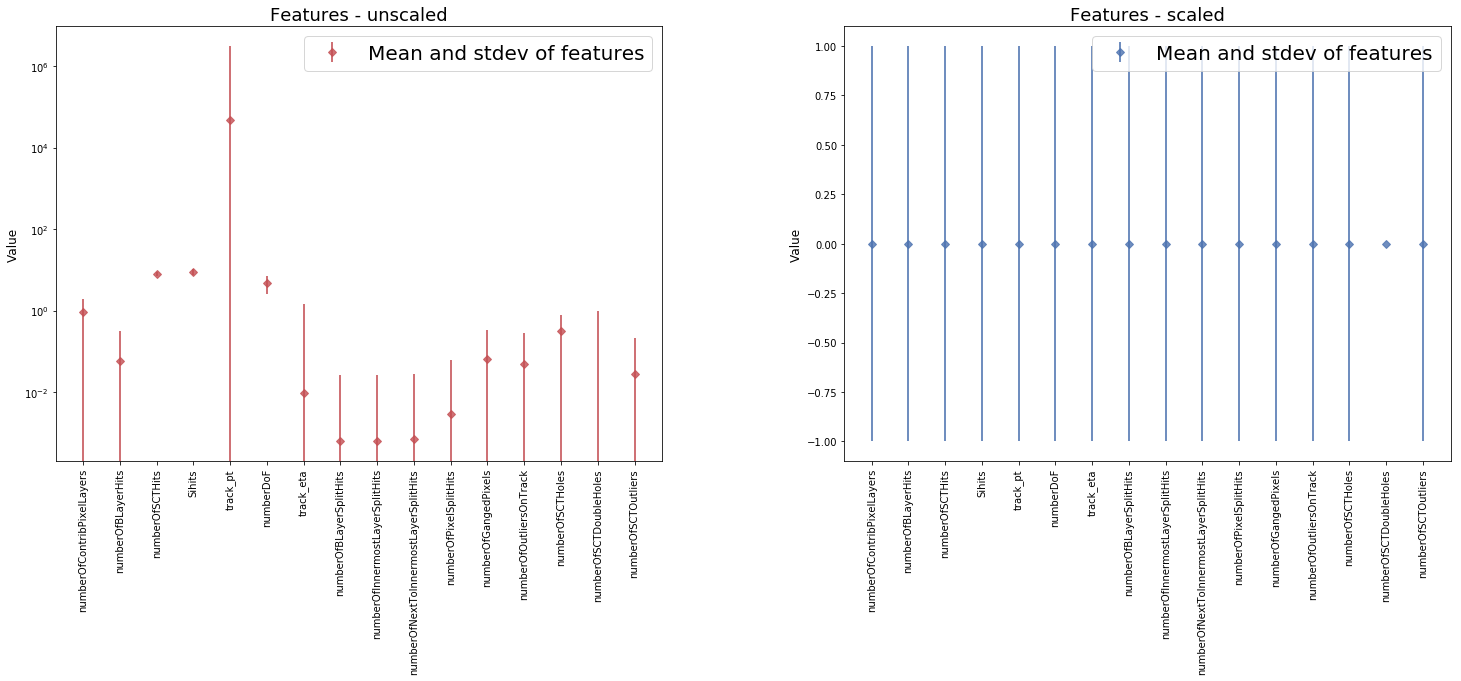

In [17]:
### Select relevant features and scale them
# This could be done with a scikitlearn utility, but we're interested in recording the exact values of scaling and offset.
# The LWTNN library uses scaling and offset information for each variable to automatically 
# pre-process the variables within athena.

label_names = ["signal"]

inputs_names = [

"numberOfContribPixelLayers",
"numberOfBLayerHits",
# "numberOfGangedFlaggedFakes", # Badly modelled in MC
# "numberOfPixelHits", # Badly modelled in MC
"numberOfSCTHits",
"Sihits",
# "standardDeviationOfChi2OS", # Badly modelled in MC
"track_pt",
# "chiSquared", # Badly modelled in MC
"numberDoF",
    
# "score", #does nothing to help
"track_eta",
# 'numberOfInnermostPixelLayerHits', # Badly modelled in MC
# 'numberOfNextToInnermostPixelLayerHits', # Badly modelled in MC
    
# These variables need closer analysis. 
# They have significant separation between good and fake tracks, 
# but they don't seem to obviously improve the network performance.
"numberOfBLayerSplitHits",
"numberOfInnermostLayerSplitHits",
"numberOfNextToInnermostLayerSplitHits",
"numberOfPixelSplitHits",

"numberOfGangedPixels",
"numberOfOutliersOnTrack",
]
if len(df["numberOfPixelHoles"].unique()) > 1:
    inputs_names.extend([
    # Only used in output (fitted) tracks
#     "numberOfPixelHoles", # Badly modelled in MC
    "numberOfSCTHoles",
    "numberOfSCTDoubleHoles",
#     "numberOfPixelOutliers",
    "numberOfSCTOutliers",
#     "numberOfPixelSpoiltHits", 
#     "numberOfSCTSpoiltHits",
    ])


# Prepare for saving information to lwtnn
# See https://github.com/dguest/lwtnn-tutorial-for-btaggers for motivation for this section
variables_json = {'inputs': [],
                  'class_labels': ["nn_score"]}

# Manual scaling to save scale and offset params for lwtnn (otherwise could use skliearn scale)
X = np.array(df[inputs_names])
X_mean = X.mean(axis=0)
X = X - X_mean # offset
X_std = X.std(axis=0)
# Don't divide by 0. These values are all the same (probably zero) and will be ignored as null values in training.
X_std[X_std==0] = 1
X = X/X_std # scale
for i in range(len(inputs_names)):
    variable_dict = {'name': inputs_names[i], 'offset': -X_mean[i], 'scale': 1/X_std[i] }
    variables_json['inputs'].append(variable_dict)

# now we save some things (create a subdirectory to keep it clean)
model_dir = dir_name+'model'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
print()
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
print("variables.json written to {}".format(model_dir))
    
# Don't scale this. Keep the labels binary
Y = np.array(df[label_names])

# Split into training and validation sets
X_train = X[0 : int(0.8*len(X))]
X_val =  X[int(0.8*len(X)) : len(X)]
Y_train = Y[0 : int(0.8*len(Y))]
Y_val =  Y[int(0.8*len(Y)) : len(Y)]

# Keep track of the weights
train_weights = track_weights[0 : int(0.8*len(X))]
val_weights =  track_weights[int(0.8*len(X)) : len(X)]

# Check the samples are consistent
assert(len(X_train) == len(Y_train))
assert(len(X_train) == len(train_weights))
assert(len(X_val) == len(Y_val))
assert(len(X_val) == len(val_weights))

# Plot features
X_mean_new = X.mean(axis=0)
X_std_new = X.std(axis=0)

labels = inputs_names
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,8))
ax1.semilogy(labels, np.array(X_mean), alpha=0, label='Track')
unscaled = ax1.errorbar(labels, np.array(X_mean), yerr=X_std, fmt='D', color='#C44E52', ecolor='#C44E52', linewidth=2, alpha = 0.8, label='_nolegend_')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend([unscaled],["Mean and stdev of features"], fontsize=20)
ax1.set_title("Features - unscaled", fontsize=18)
ax1.set_ylabel("Value", fontsize=12)

ax2.plot(labels, np.array(X_mean_new), alpha=0, label='Track')
scaled = ax2.errorbar(labels, np.array(X_mean_new), yerr=X_std_new, fmt='D', color='#4C72B0', ecolor='#4C72B0', linewidth=2, alpha = 0.8, label='_nolegend_')
ax2.xaxis.set_tick_params(rotation=90)
ax2.legend([scaled],["Mean and stdev of features"], fontsize=20)
ax2.set_title("Features - scaled", fontsize=18)
ax2.set_ylabel("Value", fontsize=12)

plt.subplots_adjust(wspace = 0.3)

In [18]:
### Callback functions

# Functions for visualization
# These are useful plots to watch when in a notebook environment
# They should show the learning curves of the loss function and the accuracy metric

# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.pred_good = np.array([])
        self.pred_fake = np.array([])
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharex=False)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Training set loss")
        ax1.plot(self.x, self.val_losses, label="Validation set loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="Training set accuracy")
        ax2.plot(self.x, self.val_acc, label="Validation set accuracy")
        ax2.legend()
        
        if (epoch % 10 == 0):
            predictions = model.predict(X_val)
            self.pred_good = predictions[Y_val.flatten() == 1]
            self.pred_fake = predictions[Y_val.flatten() == 0]

        x = [self.pred_good, self.pred_fake]
        edgecolors = ['#4C72B0','#55A868']
        for i in [0,1]:
            ax3.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,90))
        ax3.set_xlabel("Value", fontsize=12)
        ax3.set_ylabel("Tracks", fontsize=12)
        ax3.set_title("NN precidction", fontsize=18)
        ax3.legend(['good', 'fake'], loc='upper center')
#         ymin, ymax = plt.ylim()
#         plt.ylim(ymin,ymax*1.1)
        plt.show();
        
plot = PlotLearning()


checkpoint_path = dir_name + "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_weights_only=True,
                                                  save_best_only=True,
                                                  monitor='val_loss', 
                                                  mode='min',
                                            )

# Create early stopping callback
early_stop = EarlyStopping(patience=40, restore_best_weights=True)


class GetBest(Callback):
    """Get the best model at the end of training.
    # Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
    # Example
        callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
        mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)
        
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
### Define the network
# Different architectures have been tested but not rigorously. A grid search my help find optimal hyperparameters.

n_variables = X_train.shape[1]
print("Input tensor shape (examples, features):", X_train.shape)

# Create model
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(n_variables, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables*3, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(n_variables*2, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
#     model.add(keras.layers.Dense(12, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer = keras.optimizers.Adamax(lr=0.0003),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

model = create_model()
print(model.summary())

Input tensor shape (examples, features): (252878, 16)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 48)                816       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 

In [20]:
### Train model, this will take some time
# Note: this cell can be run again to train even more, as long as the model is not re-made, the optomizer will maintain its last state

# Fit the model
history = model.fit(X_train, Y_train, epochs=10000, batch_size=5000000 , 
                    callbacks=[plot, early_stop, GetBest(monitor='val_acc', verbose=1, mode='max') ], 
                    validation_data=(X_val, Y_val, ),
#                     sample_weight = train_weights
                   )

KeyboardInterrupt: 

In [21]:
# Rough evaluation of the model. See below for more precise metrics.
scores = model.evaluate(X_val, Y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

63220/63220 [==============================] - 2s 29us/sample - loss: 0.4214 - acc: 0.7876 - f1_m: 0.7828 - precision_m: 0.7814 - recall_m: 0.7944

acc: 78.76%


In [22]:
### Saving the model
# Now that the model is trained, we want to save it in a format that lwtnn can use
# the lwtnn converters prefer specific formats of network models and weights.
# The lines below should save things correctly

# Create a time-stamped subdirectory to keep clean records
model_dir = dir_name+'model/'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the architecture as json
with open('{}/arch.json'.format(model_dir),'w') as archetecture:
    archetecture.write(model.to_json(indent=2, sort_keys=True) )
    
# Save the weights as hdf5
model.save_weights('{}/weights.h5'.format(model_dir), save_format='h5')

# Save the variables (calculated in previous section)
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
# print("variables.json written to {}".format(model_dir))

# Save the summary. Lwtnn doesn't require this but it can be good reference.
with open('{}/summary.txt'.format(model_dir),'w') as summary:
    model.summary(print_fn=lambda x: summary.write(x + '\n'))

# Additionally we can save the network in a format that Keras can pick up and use later
# Note: the optimizer state cannot be saved, so the network cannot be trained on further
# from its current state, but it can be used to evaluate new samples and analyze performance
model.save('{}/model-keras.json'.format(model_dir))
    
print("Model saved to {}/".format(model_dir))

Model saved to /fast_scratch/rnewhous/LRT/training/model/20200506_080420/


In [23]:
# We can take care of converting the network to lwtnn format right here
# Note: This converter is slightly different than the one the current version of lwtnn at the time of this writing
# I needed to make a small change in the structure of the converter.
# k2j = './converters/keras2json.py'
k2j = 'converters/keras2json.py'
k2j_command = k2j + " {0}/arch.json {0}/variables.json {0}/weights.h5 > {0}/nn-config.json".format((model_dir))
# print(k2j_command)
if(os.system(k2j_command) == 0): print("Success, model saved in lwtnn format\n{}/nn-config.json".format(model_dir))
else: print("Failed to save model")
    

Success, model saved in lwtnn format
/fast_scratch/rnewhous/LRT/training/model/20200506_080420/nn-config.json


In [25]:
# # in case you want to load an old model
# model_dir_load = "/fast_scratch/rnewhous/LRT/training/model/20200506_080420/"
# json_file = open(model_dir_load+'arch.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = keras.models.model_from_json(loaded_model_json)
# loaded_model.load_weights(model_dir_load+'weights.h5')
# model = loaded_model
# print("Loaded model from disk")
# model.compile(loss='binary_crossentropy', 
#               optimizer = keras.optimizers.Adamax(lr=0.0003),
#               metrics=['accuracy', f1_m, precision_m, recall_m])


# # keras.models.model_from_json("")

Loaded model from disk


In [26]:
### Evaluate the network's performance
# Now we can look in-depth at the performance of the neural network in separating the classes
# Remember however that this is only a proxy to the true metric of performance: efficiency and fake rate
# in athena's track reconstruction algorithm. That depends on relative ordering and cannot be evaluated here
# We can however measure the discrimination power and assume that it translates to preferred ordering.

# evaluate predictions
predictions = model.predict(X_val)
print("predictions finished")
predictions_cut = predictions>0.5
print("cut finished")

predictions finished
cut finished


In [27]:
# It can be useful when comparing models later on to save additional performance stats to the model directory
# https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
model_performance = {}
    
model_performance['accuracy_score'] = accuracy_score(y_true=Y_val, y_pred=predictions_cut)
print("Accuracy %.4f" % model_performance['accuracy_score'])
model_performance['f1_score'] = f1_score(y_true=Y_val, y_pred=predictions_cut)
print("F1 Score %.4f" % model_performance['f1_score'])
model_performance['precision_score'] = precision_score(y_true=Y_val, y_pred=predictions_cut)
print("Precision %.4f" % model_performance['precision_score'])
model_performance['recall_score'] = recall_score(y_true=Y_val, y_pred=predictions_cut)
print("Recall %.4f" % model_performance['recall_score'])
model_performance['confusion_matrix'] = confusion_matrix(y_true=Y_val, y_pred=predictions_cut)
print("Confusion Matrix: \n", model_performance['confusion_matrix'])    

with open('{}/model_performance.json'.format(model_dir),'w') as model_performance_file:
    json.dump(str(model_performance), model_performance_file)
print("saved to {}/model_performance.json".format(model_dir))

Accuracy 0.7876
F1 Score 0.7879
Precision 0.7816
Recall 0.7944
Confusion Matrix: 
 [[24851  6970]
 [ 6457 24942]]
saved to /fast_scratch/rnewhous/LRT/training/model/20200506_080420/model_performance.json


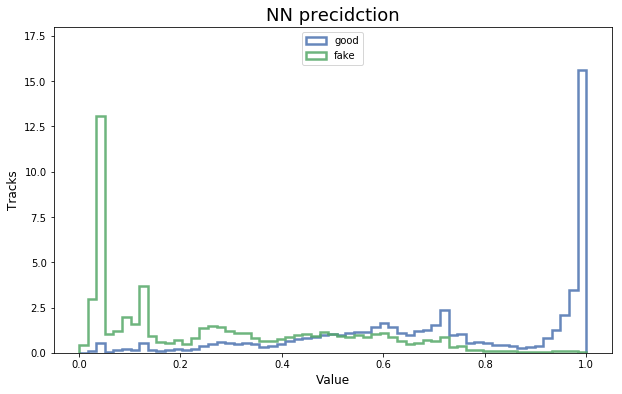

<Figure size 432x288 with 0 Axes>

In [28]:
# Visualize the NN dicriminant evaluated on good and fake tracks

pred_good = predictions[Y_val.flatten() == 1]
pred_fake = predictions[Y_val.flatten() == 0]

fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
x = [pred_good, pred_fake]
edgecolors = ['#4C72B0','#55A868']
for i in [0,1]:
    ax1.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,60))
ax1.set_xlabel("Value", fontsize=12)
ax1.set_ylabel("Tracks", fontsize=12)
ax1.set_title("NN precidction", fontsize=18)
ax1.legend(['good', 'fake'], loc='upper center')
ymin, ymax = plt.ylim()
plt.ylim(ymin,ymax*1.1)
plt.show()
plt.savefig('{}/discriminant.png'.format(model_dir),)

# From a previous study where we would cut on some nn value to remove fakes
# for cut in [0.05,0.1,0.2,0.5,0.8]:
#     total_fake = len(pred_fake)
#     remaining_fake = len(pred_fake[pred_fake>=cut])
#     print("Cutting at {}: remaining fakes: {:.2%}".format(cut, remaining_fake/total_fake))
#     total_good = len(pred_good)
#     remaining_good = len(pred_good[pred_good>=cut])
#     print("                remaining goods: {:.2%}".format(remaining_good/total_good))
    

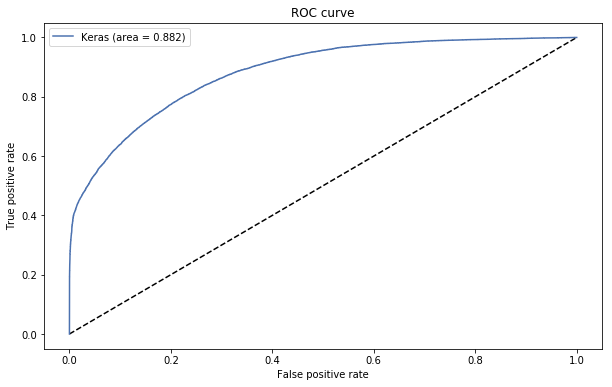

<Figure size 432x288 with 0 Axes>

In [29]:
# Plotting the ROC curve
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred_keras = predictions.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_val, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1, (10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('{}/roc.png'.format(model_dir),)
# # Zoom in view of the upper left corner.
# plt.figure(2, (10,6))
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [ ]:
################### End of useful stuff. Things beyond here are just for fun. They may not work #######################


# In[ ]:


# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_val).ravel()
y_pred_score = np.array(df['score'])[int(0.8*len(X)) : len(X)]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_val, y_pred_keras)
fpr_score, tpr_score, thresholds_score = roc_curve(Y_val, y_pred_score)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_score = auc(fpr_score, tpr_score)



plt.figure(1, (10,6))
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras), linewidth=3)
plt.plot(fpr_score, tpr_score, label='Score (area = {:.3f})'.format(auc_score), linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()
# # # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()


# In[ ]:


predictions = model.predict(X_val).ravel()


# In[ ]:




# x = predictions
# y = df_val.score
# nbins = bins = np.linspace(0,1,11)


# n, _ = np.histogram(x, bins=nbins)
# sy, _ = np.histogram(x, bins=nbins, weights=y)
# sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# fig, ax1 = plt.subplots(1, 1, figsize=(14,8))
# # Plot error bars representing stdev of entries
# ax1.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='none', ecolor='r', linewidth=2, alpha = 0.8, label='_nolegend_')
# # Plot steps of histogram
# meanscore, = ax1.step((_[1:] + _[:-1])/2 , mean, 'r', where='mid', linewidth=2, label='Mean score')
# ax1.step(_[:2] , mean[:2], 'r', where='post', linewidth=2, label='_nolegend_')
# ax1.step(_[-2:] , mean[-2:], 'r', where='pre', linewidth=2, label='_nolegend_')
# ax1.semilogy(x, y, 'b.', alpha=4e3/len(x), label='Track')

# ax1.set_ylim((10e-1,10e4))
# ax1.set_xlabel("Neural network prediction")
# ax1.set_ylabel("Track score")
# ax1.set_title("NN Score Trend")
# # Legend
# blue_line = mlines.Line2D([], [], linewidth=0, color='blue', marker='.', alpha=0.7, markersize=10, label='Tracks')
# plt.legend(handles=[meanscore,blue_line])
# plt.show()


# In[25]:


# An interesting plot of the structure of the traditional score
import seaborn as sns
from matplotlib.colors import LogNorm

pt_bins = np.logspace(2.69,5.5,700)
score_bins = np.logspace(1,4.5,700)
plt.figure(figsize=(12,10))
ax = plt.hist2d(df.track_pt, df.score, bins=[pt_bins, score_bins], norm=LogNorm())
plt.xlabel("track pt", fontsize=15)
plt.ylabel("traditional score", fontsize=15)
plt.title("Distribution of Score", fontsize=30)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")